# Demo - RBIG

This is a tldr demonstration for how we can use RBIG to Gaussianize multivariate data, estimate probabilities and draw samples from our distribution.

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))


# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.models.rbig import IterativeGaussianization

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

We are going to generate a 2D dataset and plot the joint distribution.

<Figure size 640x480 with 0 Axes>

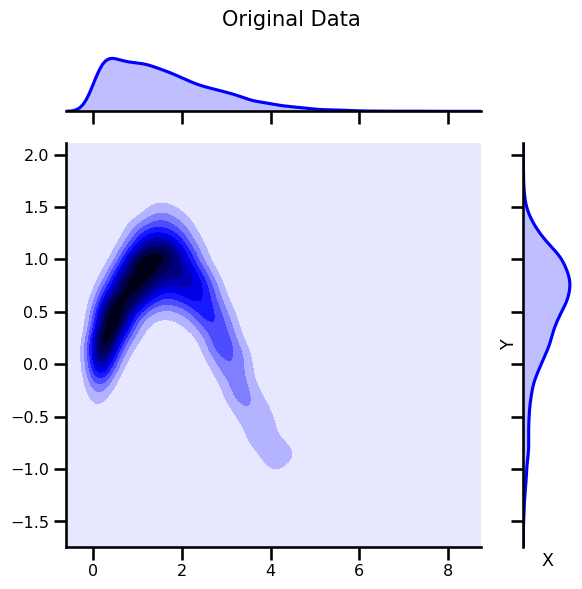

In [54]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

You can clearly see that this is not Gaussian; neither jointly nor marginally. Our objective is to use the RBIG algorithm to make this density jointly Gaussian or Gaussian.

### RBIG Object

RBIG works very similarly as an scikit-learn function. Meaning it follows the standard `transform`, `inverse_transform`, `predict_proba` and `score`.

### Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In this first example, we're going to do a single RBIG transformation to see what happens.

In [85]:
from rbig_jax.models.rbig import RBIGStandard
# intialize Gaussianization transformation
max_layers = 1

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

In [88]:
%%time
# fit rbig model
X = rbig_clf.fit_transform(data);

# check layers are the same
assert rbig_clf.n_layers == max_layers

CPU times: user 21.8 ms, sys: 3.47 ms, total: 25.3 ms
Wall time: 13.9 ms


In [89]:
%%time

# forward transform
X_trans = rbig_clf.transform(data)

CPU times: user 1.38 ms, sys: 82 µs, total: 1.47 ms
Wall time: 1.1 ms


<Figure size 640x480 with 0 Axes>

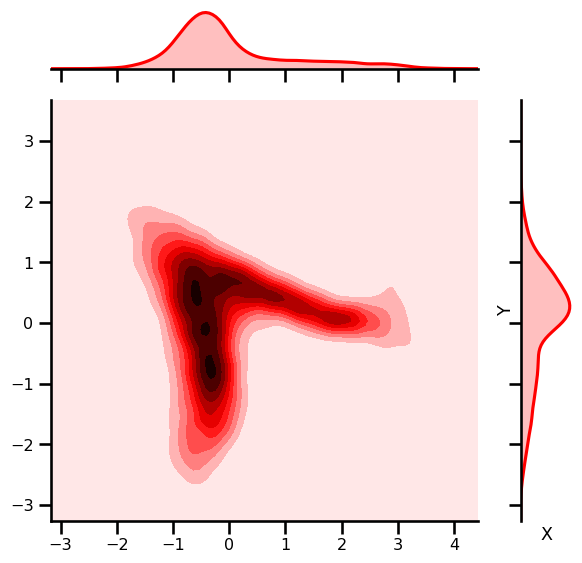

In [90]:
plot_joint(X_trans, kind="kde")

In [91]:
%%time 

# inverse transform
data_approx = rbig_clf.inverse_transform(X_trans)

# check that they're all close
chex.assert_tree_all_close(data_approx, data)

CPU times: user 12.6 ms, sys: 8.1 ms, total: 20.7 ms
Wall time: 9.96 ms


#### Adding More Layers

So this is nice because the inverse and the forward functions work. However, we can't predict and probability estimates nor can we sample without our latent space $Z$ being perfectly Gaussian (marginally and jointly). So we need to add more layers.

In [107]:
# intialize Gaussianization transformation
max_layers = 20

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

In [108]:
%%time

# fit rbig model
Xtrans = rbig_clf.fit_transform(data)

# check layers are the same
assert rbig_clf.n_layers == max_layers

CPU times: user 5.06 s, sys: 56.2 ms, total: 5.12 s
Wall time: 4.9 s


In [97]:
%%time

# forward transformation
X_trans = rbig_clf.transform(data)


CPU times: user 30 ms, sys: 5.13 ms, total: 35.1 ms
Wall time: 7.93 ms


<Figure size 640x480 with 0 Axes>

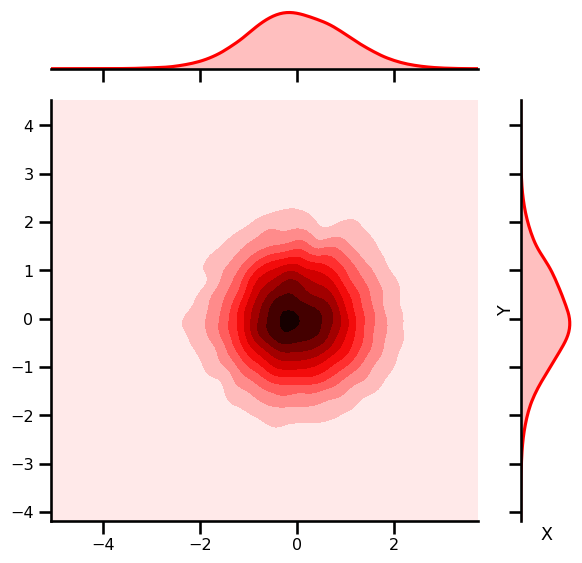

In [98]:
# plot results
plot_joint(X_trans, kind="kde")

Now our data is perfectly Gaussian. This means we can sample and we can also get probability estimates.

#### Inverse

In [100]:
%%time 

# inverse transform
data_approx = rbig_clf.inverse_transform(X_trans)

# check that they're all close
chex.assert_tree_all_close(data_approx, data)

CPU times: user 172 ms, sys: 62.8 ms, total: 235 ms
Wall time: 122 ms


#### Sample

In [101]:
%%time

# generate 10_000 random samples
data_samples = rbig_clf.sample(10_000)


CPU times: user 35.8 ms, sys: 8.55 ms, total: 44.4 ms
Wall time: 16 ms


<Figure size 640x480 with 0 Axes>

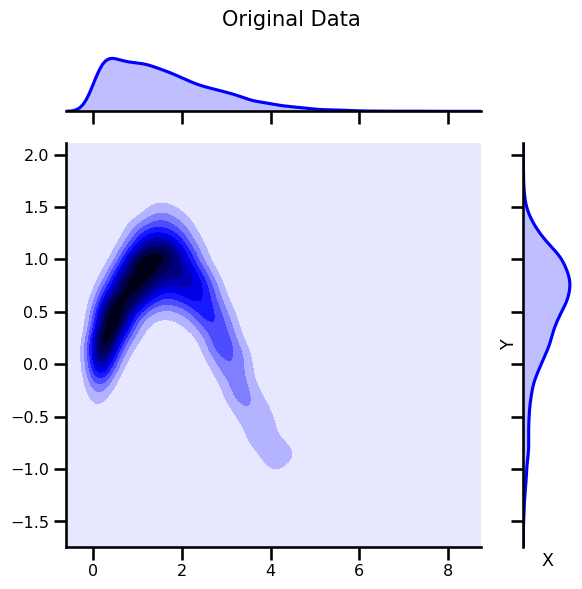

<Figure size 640x480 with 0 Axes>

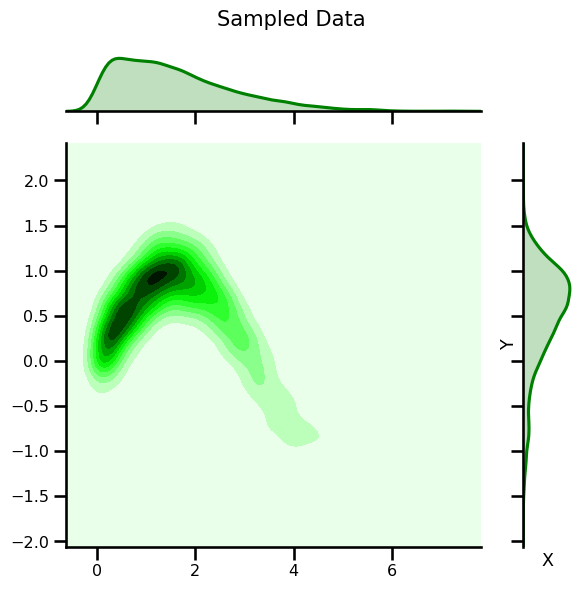

In [102]:
# plot samples
plot_joint(data, title="Original Data", color="blue", kind="kde")
plot_joint(data_samples,title="Sampled Data", color="green", kind="kde")

As you can see, our generate samples have a very similar distribution.

**note**: the more data you have to fit RBIG, the better samples you will generate.

### Stopping Criteria

Since this is an iterative technique, we need some sort of stopping criteria to know if we are fully Gaussian or not. In this method, we keep track of the marginal entropy between iterations. In theory, as the transformations make the data more and more Gaussian, there should be limited or no changes in the marginal entropy. We have an attribute called `info_loss` which keeps track of how much this has changed between iterations.

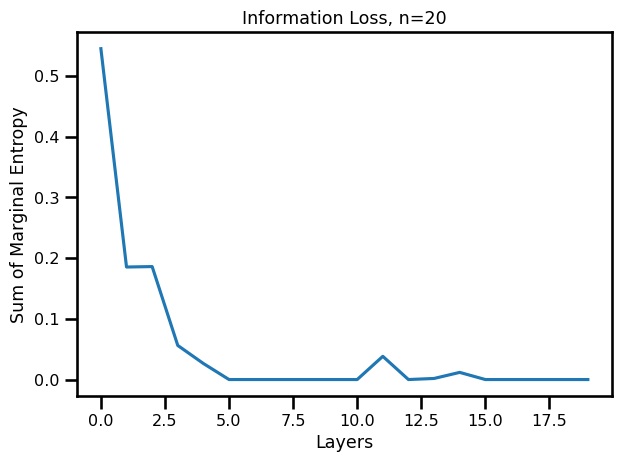

In [103]:
plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

As we can see, there is effectively no change in the information loss after about 8 layers or so. So we can stop the iterative algorithm right then and there. We set the `tol_layers` to be roughly `10`. This means we will allow `10` layers of no changes before we stop the algorithm.  It's very similar to a callback. 

So let's rerun this algorithm with our helpful stopping criteria which encompasses this "callback".

In [112]:
rbig_clf.total_correlation(2)

DeviceArray(0.72818175, dtype=float64)

In [113]:
rbig_clf.entropy(data)

DeviceArray(0.58097081, dtype=float64)

In [22]:
# initialize rbig model
rbig_clf = RBIG(
    method='histogram', 
    stopping_criteria="info", 
    tol_layers=10
)

In [24]:
%%time

X_trans = rbig_clf.fit_transform(data)

CPU times: user 9.63 s, sys: 3.92 s, total: 13.5 s
Wall time: 9.34 s


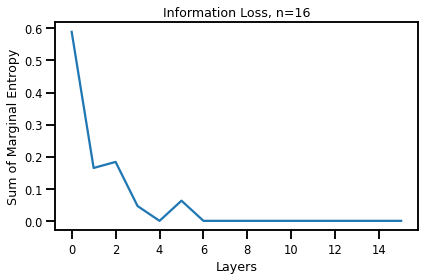

In [25]:
plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

So we have 16 layers instead of 20 full layers which saves us some iterations. Again, for this example, we were being generous with the tolerance but for bigger datasets with more dimensions, it's always a good idea to leave a larger tolerance. It's very similar to a callback.

#### Sampling

And now that we are confidence in our stopping criteria, we can sample.

In [52]:
%%time
# generate 10_000 random samples
data_samples = rbig_clf.sample(10_000)

CPU times: user 47.7 ms, sys: 6.29 ms, total: 54 ms
Wall time: 19.7 ms


<Figure size 640x480 with 0 Axes>

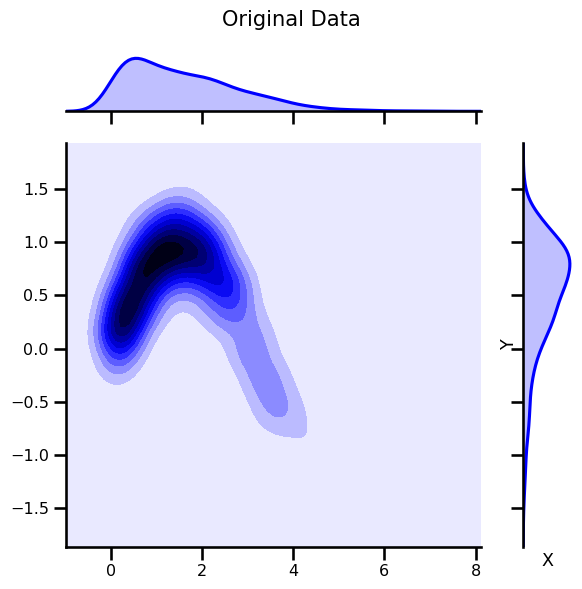

<Figure size 640x480 with 0 Axes>

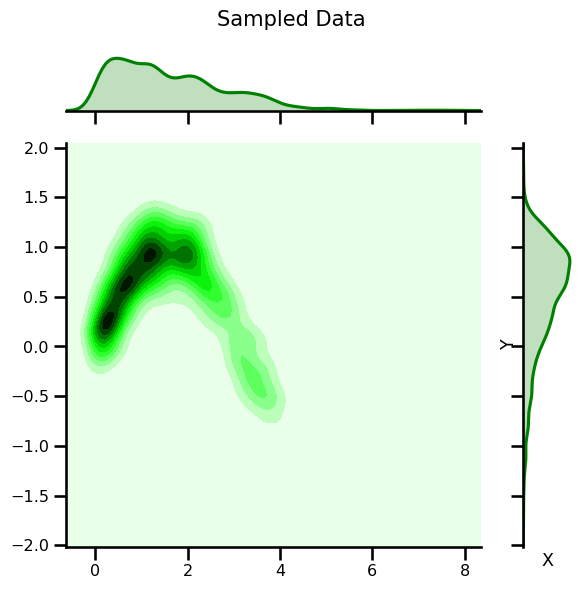

In [53]:
# plot samples
plot_joint(data, title="Original Data", color="blue", kind="kde")
plot_joint(data_samples,title="Sampled Data", color="green", kind="kde")

## Probabilities

One nice feature of this transformation is it's use in probability estimates. We can use the method `predict_proba` to calculate the probability estimates.

In [27]:
%%time


# generate some data
data_new = get_classic(10_000)

# invert the data
X_log_prob = rbig_clf.predict_proba(data_new)

CPU times: user 1.03 s, sys: 27.9 ms, total: 1.06 s
Wall time: 843 ms


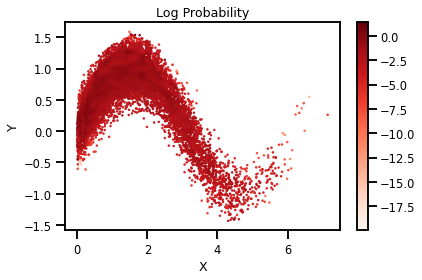

In [28]:
plot_joint_prob(data_new, X_log_prob, title="Log Probability")

Probabilities with these methods tend to have outliers so it's always a good idea to clip certain probabilities for visual purposes.

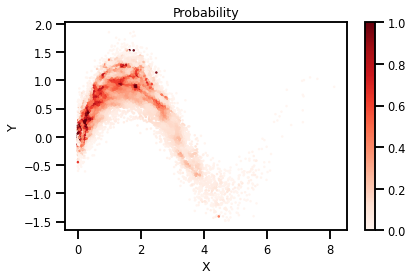

In [29]:
# convert to probability
X_prob = np.exp(X_log_prob)

# clip some extreme values
X_prob = np.clip(X_prob, 0.0, 1.0)

# plot
plot_joint_prob(data_new, X_prob, title="Probability")

### Other Marginal Density Estimators

So there are many ways we could estimate the marginal density and that will affect how well the probability estimates are. For example, we have implemented the kernel density estimator.

In [30]:
%%time

# initialize rbig model
rbig_clf = RBIG(
    method='kde', 
    stopping_criteria="info", 
    tol_layers=10
)

# fit the rbig model
rbig_clf.fit(data)

# predict probabilities
X_log_prob = rbig_clf.predict_proba(data_new)

CPU times: user 8.72 s, sys: 21.7 s, total: 30.5 s
Wall time: 3.33 s


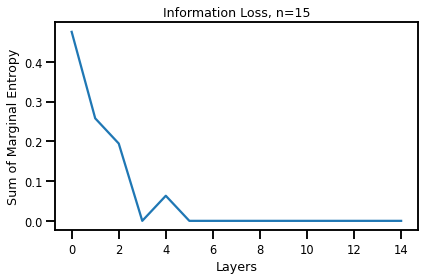

In [32]:
plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

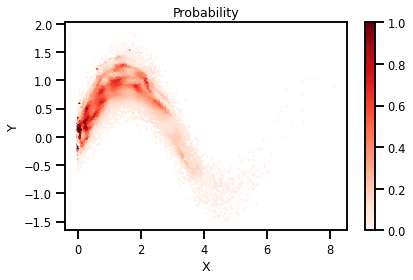

In [33]:
# convert to probability
X_prob = np.exp(X_log_prob)

# clip some extreme values
X_prob = np.clip(X_prob, 0.0, 1.0)

# plot
plot_joint_prob(data_new, X_prob, title="Probability")

Some things to notice:

1. The number of layers is less than with the histogram estimation.
2. The probability estimates are smoother.